In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)

In [2]:
tile_size = 1920
overlap = 128
y_drop = 7430
threshold = 4000

random_pattern = True
# number of PEs compute in the same time
num_PE = 64

In [3]:
W = {'A': {'A':  91, 'C': -90, 'G': -25, 'T':-100},
     'C': {'A': -90, 'C': 100, 'G':-100, 'T': -25},
     'G': {'A': -25, 'C':-100, 'G': 100, 'T': -90},
     'T': {'A':-100, 'C': -25, 'G': -90, 'T':  91}}
g_o = -430
g_e = -30

In [4]:
# W = {'A': {'A': 2, 'C':-3, 'G':-3, 'T':-3},
#      'C': {'A':-3, 'C': 2, 'G':-3, 'T':-3},
#      'G': {'A':-3, 'C':-3, 'G': 2, 'T':-3},
#      'T': {'A':-3, 'C':-3, 'G':-3, 'T': 2}}
# g_o = -7
# g_e = -2

In [5]:
f = open('sequence_1.txt', 'r')
gene_1 = ''
f.readline()
for line in f.readlines():
    gene_1 = gene_1 + line[:-1]
f.close()

f = open('sequence_2.txt', 'r')
gene_2 = ''
f.readline()
for line in f.readlines():
    gene_2 = gene_2 + line[:-1]
f.close()

print(len(gene_1), len(gene_2))

607 763


In [6]:
bias = 0
gene_1, gene_2 = gene_1[bias:bias+tile_size], gene_2[bias:bias+tile_size]
print(len(gene_1), len(gene_2))
print(gene_1)
print(gene_2)

607 763
ATGTTCTCTCGGAGGATGTATTATCTTTTGCTCATTCTAAGCACAATGCTTTCTTTCCACCTTGTGGAGGGGATTTTGGAAAATGTGCTAGCCCGTTCTACAAGTAAGAATTGATATTGATGCATTCTAAATGTAAATACATGATTTACAGCTGTCATCGTTGTATTCTATGTTATTACCAATTCAGCATATTAGCATAATATCTACATATATTTAATTCAGTATCGATTTATTTGCTTTAGTTGTGTAAAACACCCCGTTCTATGCATTACCTTGTCGCATTTGAATTCAGTAATCTTTATTTAAATGTTTTTAACTGTTTCGTTATTCTTAAAACTTCATAAATAAGAATTGTCTTCACCTGTCTCAGTAGCCATCTTTCTTTTACTTATAATTAAACCAAAAAATAATTCAGTGTATATATCTCTACGCTTACGAATGGTATTCACTATGTCTGCACACCCAAGCTGTGTTACAGGACCGACGGCATCCAAAAATAAGCATTCAATACTTAATCGTTTCAGATGAGGATAGGGAAGGCAGTATCTTCGACACTGGACCAATTCGAAGGCCAAGGCCTAGACCAAGACCAAGACCAGAGGGTTGA
ATGTTCTCTCGGAGGATTTATTATCTTTTGCTCATTTTAAGCACAATGCTTTCTTTTCACCTTGTGGAGGGGATTTTGGAAAATGTGCTAGCCCGTTCTACAAGTAAGAATTGATATTGATGCATTCTAAATGCAAATACATGATTTACAACTGTCATCGTTGTATTCTATGTTATTACCAATTCAGCATATTAGCATTATATCTACATATATTTAATTCAGTATCGATTTATTTGCTTTCGTTGTGTAAAACACCCTGTTCTATGCATTGCCTTGACGCATTTGAATTCAGTAATCTTTATTTAAATGTTTTTAACTGTTTCGTTGGTTTTGGAACTTCATAAATAAGAATTGTTTTCACGTGTCCTAGAAGCCATCTTTTTT

In [7]:
import random
random.seed(10)

d = ['A', 'C', 'G', 'T']
if random_pattern:
    gene_1, gene_2 = '', ''
    for i in range(tile_size):
        gene_1 += d[random.randint(0, 3)]
    i = 0
    while i < tile_size:
        die = random.random()
        l = random.randint(1,8)
        # delete gene_1 for length l
        if die < 0.05:
            i += l
        # insert gene_1 for length l
        elif die < 0.1:
            for j in range(l):
                gene_2 += d[random.randint(0, 3)]
            i += 1
        # change 1 gene
        elif die < 0.15:
            gene_2 += d[random.randint(0, 3)]
            i += 1
        else:
            gene_2 += gene_1[i]
            i += 1
    while len(gene_2) < tile_size:
        gene_2 += d[random.randint(0, 3)]
            
    print(len(gene_1), len(gene_2))
    print(gene_1)
    print(gene_2)

1920 1920
ATTACTTGCATGACGATCGTTGGTCGGCTCTTAACCCGGCGTTTAGCCTCAATGAACTGCAATCCGTTTCGCCAGTGCCCTGGTCAAGGCAGTTCTTCGTTACTTTCTGTTCTATAATAAGACATTCTTTGGTTGCCGACTAAGTCGAAAGCTCGTCGCACTCAGTTTCGGAACTTTCATAAGGGTTCGTGTGTTGGGTTTTAGTCTAGAGGATGGCCCGAACATCTATCGCGAAAGTGCCAGCAGATTGACTTTTCGTGTTCATCACCTGTAACGCACAGCGATTAGCTCCTTGACCTCTATACATGGAGTCGACTCATATCGGACAATAATGCAGGTCACCGCCCTTACAAAACATAATCTACATTTGCATTTGACGGCATACGAGCAAGGAGTCAAACACCGTCAGATGTTCCATCTCGTCATTCTGCTGTCGGCATAGATAACAAGTCTAAAGTTGCCTCCCTCTTCACCATTACATCCGTCCGGGCATTGGAGGATGTCATTAATCATAAGTATATTCTATTTTGCTCCTTTTGTAGTGCCCGCAAACTGCCACTGACAACTTGATGGACGACCATGGGTGGTAATGTTTGACCGGCATACCTGTATCCATAGTAACCCTTCTCTTCCGTCCACCATACGGTCTCTTTATACAAAGCGGGGCGCAATATACCTCTTACAGGCATAAATTGGGCTGGAGGGAGTGTTTCGACCATGTGCGCCAACCAGGTGGGACGAACTCGGATGTAGGTTGTAGGTCCTTGGAGAAAGTCCCAGCGCACGAGTCTATCAGCACTGGATCCTATTTAACGTCTTCGCGAACACCGCATTATGACCCGAGCTTACTAGCTTGATGAGAAGTAACCACTAAGATGGGTGTAATCATGGAAGTGGCCGTAGCGAGAGAGACAGCGAGTTTGACGCGGGTATCCTGGCTAACTCCAAGGACAAATCATTGAAACATGAGAGCCTCTGGCTATCTGCGCG

In [8]:
# tile_size = 52
# gene_1 = gene_1[:tile_size]
# gene_2 = gene_2[:tile_size]
# print(gene_1)
# print(gene_2)

# Normal version

In [9]:
# Score matrix
V = np.zeros((tile_size+1, tile_size+1))
I = np.zeros((tile_size+1, tile_size+1))
D = np.zeros((tile_size+1, tile_size+1))
for i in range(1, tile_size+1):
    V[0, i] = g_o + (i-1)*g_e
    V[i, 0] = g_o + (i-1)*g_e
    D[0, i] = float('-inf')
    D[i, 0] = g_o + (i-1)*g_e
    I[0, i] = g_o + (i-1)*g_e
    I[i, 0] = float('-inf')
print('Score matrix')
print(V)
print('Insertion matrix (Score when direction is left)')
print(I)
print('Deletion matrix (Score when direction is top)')
print(D)
# Direction matrix, 0:no compute, 1:top-left, 2:top, 3:left
Trace = np.zeros((tile_size+1, tile_size+1), dtype=int)
# When direction = 'left' or 'top', we needs to trace next direction on 'Trace_I' or 'Trace_D' instead of 'Trace'
# 0:from Trace_I or Trace_D (extend gap), 1:from Trace (new gap)
Trace_I = np.zeros((tile_size+1, tile_size+1), dtype=int)
Trace_D = np.zeros((tile_size+1, tile_size+1), dtype=int)

Score matrix
[[     0.   -430.   -460. ... -57940. -57970. -58000.]
 [  -430.      0.      0. ...      0.      0.      0.]
 [  -460.      0.      0. ...      0.      0.      0.]
 ...
 [-57940.      0.      0. ...      0.      0.      0.]
 [-57970.      0.      0. ...      0.      0.      0.]
 [-58000.      0.      0. ...      0.      0.      0.]]
Insertion matrix (Score when direction is left)
[[     0.   -430.   -460. ... -57940. -57970. -58000.]
 [   -inf      0.      0. ...      0.      0.      0.]
 [   -inf      0.      0. ...      0.      0.      0.]
 ...
 [   -inf      0.      0. ...      0.      0.      0.]
 [   -inf      0.      0. ...      0.      0.      0.]
 [   -inf      0.      0. ...      0.      0.      0.]]
Deletion matrix (Score when direction is top)
[[     0.    -inf    -inf ...    -inf    -inf    -inf]
 [  -430.      0.      0. ...      0.      0.      0.]
 [  -460.      0.      0. ...      0.      0.      0.]
 ...
 [-57940.      0.      0. ...      0.      0.      

In [10]:
V_max = float('-inf')
x_max, y_max = 0, 0
i,j = 1,1
print(V[i-1][j-1] + W[gene_1[i-1]][gene_2[j-1]])
print(V[i][j-1]+g_o, I[i][j-1]+g_e)
print(V[i-1][j]+g_o, D[i-1][j]+g_e)

for i in range(1, tile_size+1):
    for j in range(1, tile_size+1):
        V_nxt = V[i-1][j-1] + W[gene_1[i-1]][gene_2[j-1]]
        I[i][j] = max(V[i][j-1]+g_o, I[i][j-1]+g_e)
        D[i][j] = max(V[i-1][j]+g_o, D[i-1][j]+g_e)
        V[i][j] = max(V_nxt, I[i][j], D[i][j])
        # if new maximum
        if V[i][j] >= V_max:
            V_max = V[i][j]
            x_max, y_max = i, j
        # direction of Trace
        if V[i][j] == V_nxt:
            Trace[i][j] = 1
        elif V[i][j] == D[i][j]:
            Trace[i][j] = 2
        elif V[i][j] == I[i][j]:
            Trace[i][j] = 3
        # direction of Trace_I
        if I[i][j] == V[i][j-1]+g_o:
            Trace_I[i][j] = 1
        else:
            Trace_I[i][j] = 0
        # direction of Trace_D
        if D[i][j] == V[i-1][j]+g_o:
            Trace_D[i][j] = 1
        else:
            Trace_D[i][j] = 0
    # print(V_max)
print('Score matrix')
print(V)
print('Insertion matrix (Score when direction is left)')
print(I)
print('Deletion matrix (Score when direction is top)')
print(D)
print('Direction')
print(Trace)
print('Direction of I')
print(Trace_D)
print('Direction of D')
print(Trace_I)
print(V_max, x_max, y_max)

91.0
-860.0 -inf
-860.0 -inf
Score matrix
[[     0.   -430.   -460. ... -57940. -57970. -58000.]
 [  -430.     91.   -339. ... -57819. -57849. -57879.]
 [  -460.   -339.    182. ... -57698. -57728. -57758.]
 ...
 [-57940. -57819. -57698. ...  63283.  63156.  63223.]
 [-57970. -57849. -57728. ...  63289.  63183.  63066.]
 [-58000. -57879. -57758. ...  63219.  63189.  63159.]]
Insertion matrix (Score when direction is left)
[[     0.   -430.   -460. ... -57940. -57970. -58000.]
 [   -inf   -860.   -339. ... -57819. -57849. -57879.]
 [   -inf   -890.   -769. ... -57698. -57728. -57758.]
 ...
 [   -inf -58370. -58249. ...  63093.  63063.  63033.]
 [   -inf -58400. -58279. ...  63098.  63068.  63038.]
 [   -inf -58430. -58309. ...  63219.  63189.  63159.]]
Deletion matrix (Score when direction is top)
[[     0.    -inf    -inf ...    -inf    -inf    -inf]
 [  -430.   -860.   -890. ... -58370. -58400. -58430.]
 [  -460.   -339.   -769. ... -58249. -58279. -58309.]
 ...
 [-57940. -57819. -576

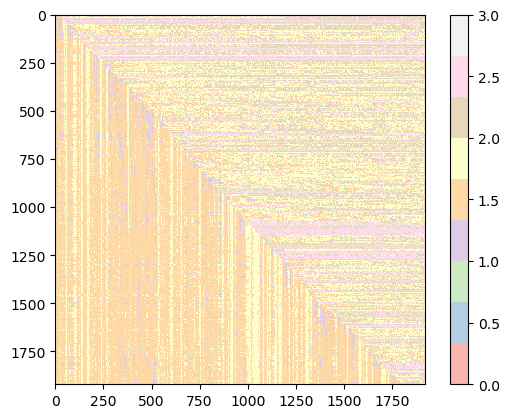

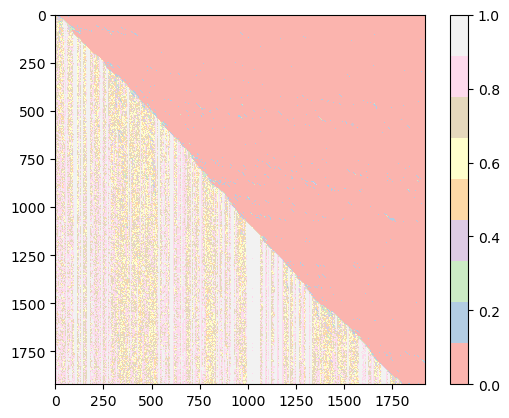

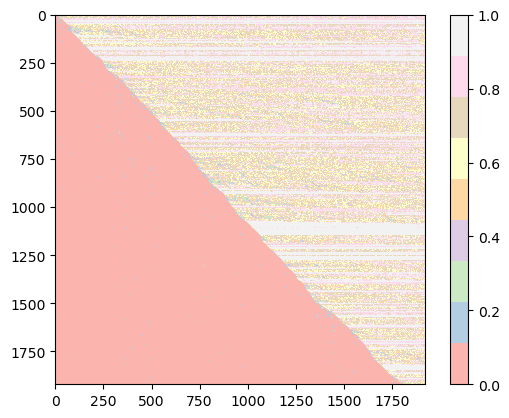

In [11]:
Trace_ans = Trace
Trace_I_ans = Trace_I
Trace_D_ans = Trace_D
plt.imshow(Trace[:, :], cmap='Pastel1')
plt.colorbar()
plt.show()
plt.imshow(Trace_I[:, :], cmap='Pastel1')
plt.colorbar()
plt.show()
plt.imshow(Trace_D[:, :], cmap='Pastel1')
plt.colorbar()
plt.show()

Score: 66965.0, Position: (1911, 1793)


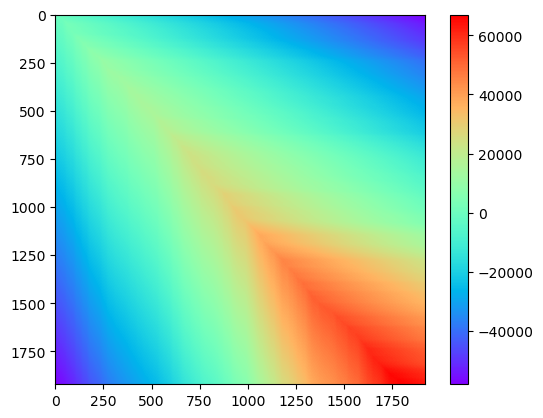

In [12]:
V_ans = V
print(f'Score: {V_max}, Position: {x_max, y_max}')
plt.imshow(V[:, :], cmap='rainbow')
plt.colorbar()
plt.show()

In [13]:
seq_1 = ''
seq_2 = ''
result = ''
# which matirx are we tracking now
target_matrix = 'T'

x, y = x_max, y_max
while(x != 0) and (y != 0):
    if target_matrix == 'T':
        # print('T', Trace[x][y], x, y)
        if Trace[x][y] == 1:
            seq_1 = gene_1[x-1] + seq_1
            seq_2 = gene_2[y-1] + seq_2
            if gene_1[x-1] == gene_2[y-1]:
                result = '|' + result
            else:
                result = ' ' + result
            x, y = x-1, y-1
        # if direction = top, move to Trace_D
        elif Trace[x][y] == 2:
            if Trace_D[x][y] == 0:
                target_matrix = 'D'
            seq_1 = gene_1[x-1] + seq_1
            seq_2 = '-' + seq_2
            result = ' ' + result
            x, y = x-1, y
        # if direction = left, move to Trace_I
        elif Trace[x][y] == 3:
            if Trace_I[x][y] == 0:
                target_matrix = 'I'
            seq_1 = '-' + seq_1
            seq_2 = gene_2[y-1] + seq_2
            result = ' ' + result
            x, y = x, y-1
    elif target_matrix == 'D':
        # print('D', Trace_D[x][y], x, y)
        # move to Trace if reach gap origin
        if Trace_D[x][y] == 1:
            target_matrix = 'T'
        seq_1 = gene_1[x-1] + seq_1
        seq_2 = '-' + seq_2
        result = ' ' + result
        x, y = x-1, y
    elif target_matrix == 'I':
        # print('I', Trace_I[x][y], x, y)
        # move to Trace if reach gap origin
        if Trace_I[x][y] == 1:
            target_matrix = 'T'
        seq_1 = '-' + seq_1
        seq_2 = gene_2[y-1] + seq_2
        result = ' ' + result
        x, y = x, y-1

width = 60
parts = len(seq_1)//width + 1
print(f'Score: {V_max}, Position: {x_max, y_max}')
for i in range(parts):
    print(seq_1[i*width:min(i*width+width, len(seq_1))])
    print(result[i*width:min(i*width+width, len(result))])
    print(seq_2[i*width:min(i*width+width, len(seq_2))])
    print('')

seq_1_ans = seq_1
seq_2_ans = seq_2
result_ans = result

Score: 66965.0, Position: (1911, 1793)
ATTACTTG-------CATGACGAT-----CGTTGGTCGGCTCTTAACCCGGCGTTTAGCC
||| | ||       |||||| ||     ||||||||| ||||||||||||| |||||||
ATTGCGTGGGCATTTCATGACCATGTTTCCGTTGGTCGCCTCTTAACCCGGCTTTTAGCC

TCA--ATGAACTGCAATCCGTTTCGCCAGTGCCCTGGTCAAGGCAGTTCTTCGTTACTTT
||   ||||        ||||       ||||||| |||    ||  |||||||||||||
TCGCCATGA--------CCGT-------GTGCCCTCGTC----CAACTCTTCGTTACTTT

CTGTTCTATAA--TAAGACATTCTTTGGTTGCCGACTAAGTCGAAAGCTCGTCGCACTCA
|||||||||||  | || ||||||||||  |||||||||||||||| | |  || |  ||
CTGTTCTATAATCTGAGCCATTCTTTGG--GCCGACTAAGTCGAAA-CGCCACGTAGCCA

GTTTCGGAACTTTCATAAGGGTTCGTGTG-TTGGGTTTTAG---TCTAGAG-------GA
|||||||||||||||||||||| || |   ||||||||||    |||||||       ||
GTTTCGGAACTTTCATAAGGGTGCGGGCACTTGGGTTTTAACATTCTAGAGGAACTACGA

TGGCCCGAACATCTATCGCGAAAGTGCCAGCAGATTGACTTTTCGTGTTCATCACCTGTA
|||||||||||| |||||||||||||||       |||||||||        ||||   |
TGGCCCGAACATATATCGCGAAAGTGCC-------TGACTTTTC--------CACC---A

ACGCACAGCGATTAG-------CTCCTTGACCT--CTATA-

In [14]:
# checking calculation
score = 0
for i in range(len(seq_1)):
    if seq_1[i] == '-':
        if seq_1[i-1] == '-':
            score += g_e
        else:
            score += g_o
    elif seq_2[i] == '-':
        if seq_2[i-1] == '-':
            score += g_e
        else:
            score += g_o
    else:
        score += W[seq_1[i]][seq_2[i]]
print(score)

66965


# With stripe (No banded)

In [15]:
# Score matrix
V = np.zeros((tile_size+1, tile_size+1))
V = V + float('-inf')
V[0][0] = 0
I = np.zeros((tile_size+1, tile_size+1))
D = np.zeros((tile_size+1, tile_size+1))
for i in range(1, tile_size+1):
    V[0, i] = g_o + (i-1)*g_e
    V[i, 0] = g_o + (i-1)*g_e
    D[0, i] = float('-inf')
    D[i, 0] = g_o + i*g_e
    I[0, i] = g_o + i*g_e
    I[i, 0] = float('-inf')
print('Score matrix')
print(V)
print('Insertion matrix (Score when direction is left)')
print(I)
print('Deletion matrix (Score when direction is top)')
print(D)
# Direction matrix, 0:no compute, 1:top-left, 2:top, 3:left
Trace = np.zeros((tile_size+1, tile_size+1), dtype=int)
# When direction = 'left' or 'top', we needs to trace next direction on 'Trace_I' or 'Trace_D' instead of 'Trace'
# 0:from Trace_I or Trace_D (extend gap), 1:from Trace (new gap)
Trace_I = np.zeros((tile_size+1, tile_size+1), dtype=int)
Trace_D = np.zeros((tile_size+1, tile_size+1), dtype=int)

Score matrix
[[     0.   -430.   -460. ... -57940. -57970. -58000.]
 [  -430.    -inf    -inf ...    -inf    -inf    -inf]
 [  -460.    -inf    -inf ...    -inf    -inf    -inf]
 ...
 [-57940.    -inf    -inf ...    -inf    -inf    -inf]
 [-57970.    -inf    -inf ...    -inf    -inf    -inf]
 [-58000.    -inf    -inf ...    -inf    -inf    -inf]]
Insertion matrix (Score when direction is left)
[[     0.   -460.   -490. ... -57970. -58000. -58030.]
 [   -inf      0.      0. ...      0.      0.      0.]
 [   -inf      0.      0. ...      0.      0.      0.]
 ...
 [   -inf      0.      0. ...      0.      0.      0.]
 [   -inf      0.      0. ...      0.      0.      0.]
 [   -inf      0.      0. ...      0.      0.      0.]]
Deletion matrix (Score when direction is top)
[[     0.    -inf    -inf ...    -inf    -inf    -inf]
 [  -460.      0.      0. ...      0.      0.      0.]
 [  -490.      0.      0. ...      0.      0.      0.]
 ...
 [-57970.      0.      0. ...      0.      0.      

In [16]:
# start position of next PE stripe
column_start_nxt = 1
V_max = 0
x_max, y_max = 0, 0
# 4 PEs compute in the same time
for i in range(1, tile_size+1, 4):
    column_start_nxt_determined = False
    # column = column_start_nxt # current row
    column = 1
    stripe_end = False
    while not stripe_end:
        # row index: i+j, column index:column
        for j in range(4):
            # print(i+j, column)
            V_nxt = V[i+j-1][column-1] + W[gene_1[i+j-1]][gene_2[column-1]]
            I[i+j][column] = max(V[i+j][column-1]+g_o, I[i+j][column-1]+g_e)
            D[i+j][column] = max(V[i+j-1][column]+g_o, D[i+j-1][column]+g_e)
            V[i+j][column] = max(V_nxt, I[i+j][column], D[i+j][column])
            # print(i+j, column, V[i+j][column])
            # track max score
            if V[i+j][column] >= V_max:
                V_max = V[i+j][column]
                x_max, y_max = i+j, column
            # track direction
            if V[i+j][column] == V_nxt:
                Trace[i+j][column] = 1
            elif V[i+j][column] == D[i+j][column]:
                Trace[i+j][column] = 2
            elif V[i+j][column] == I[i+j][column]:
                Trace[i+j][column] = 3
            # direction of Trace_I
            if I[i+j][column] == V[i+j][column-1]+g_o:
                Trace_I[i+j][column] = 1
            else:
                Trace_I[i+j][column] = 0
            # direction of Trace_D
            if D[i+j][column] == V[i+j-1][column]+g_o:
                Trace_D[i+j][column] = 1
            else:
                Trace_D[i+j][column] = 0
            
        # if stripe end
        if column == tile_size:
            stripe_end = True
        '''
        elif (V[i][column]<V_max-y_drop) & (V[i+1][column]<V_max-y_drop) & (V[i+2][column]<V_max-y_drop) & (V[i+3][column]<V_max-y_drop):
            stripe_end = True
        '''
        # next stripe start position
        if not column_start_nxt_determined:
            if (V[i][column]>V_max-y_drop) & (V[i+1][column]>V_max-y_drop) & (V[i+2][column]>V_max-y_drop) & (V[i+3][column]>V_max-y_drop):
                column_start_nxt = column
                column_start_nxt_determined =True
        # PE shift to next column
        column += 1

print('Score matrix')
print(V)
print('Insertion matrix (Score when direction is left)')
print(I)
print('Deletion matrix (Score when direction is top)')
print(D)
print('Direction')
print(Trace)
print(V_max, x_max, y_max)

Score matrix
[[     0.   -430.   -460. ... -57940. -57970. -58000.]
 [  -430.     91.   -339. ... -57819. -57849. -57879.]
 [  -460.   -339.    182. ... -57698. -57728. -57758.]
 ...
 [-57940. -57819. -57698. ...  63283.  63156.  63223.]
 [-57970. -57849. -57728. ...  63289.  63183.  63066.]
 [-58000. -57879. -57758. ...  63219.  63189.  63159.]]
Insertion matrix (Score when direction is left)
[[     0.   -460.   -490. ... -57970. -58000. -58030.]
 [   -inf   -860.   -339. ... -57819. -57849. -57879.]
 [   -inf   -890.   -769. ... -57698. -57728. -57758.]
 ...
 [   -inf -58370. -58249. ...  63093.  63063.  63033.]
 [   -inf -58400. -58279. ...  63098.  63068.  63038.]
 [   -inf -58430. -58309. ...  63219.  63189.  63159.]]
Deletion matrix (Score when direction is top)
[[     0.    -inf    -inf ...    -inf    -inf    -inf]
 [  -460.   -860.   -890. ... -58370. -58400. -58430.]
 [  -490.   -339.   -769. ... -58249. -58279. -58309.]
 ...
 [-57970. -57819. -57698. ...  62751.  62724.  6266

In [17]:
print(Trace_ans.all() == Trace.all())
print(Trace_I_ans.all() == Trace_I.all())
print(Trace_D_ans.all() == Trace_D.all())
print(V_ans.all() == V.all())

True
True
True
True


1911 1793


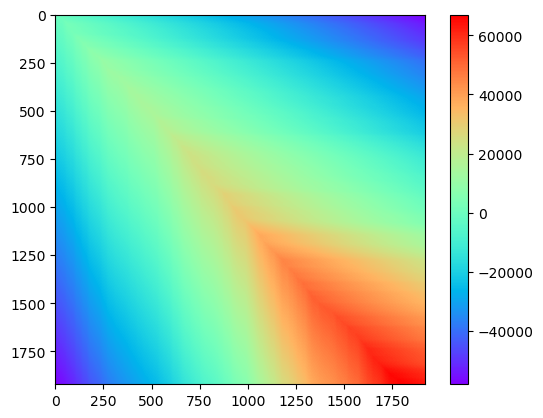

In [18]:
print(x_max, y_max)
plt.imshow(V[:, :], cmap='rainbow')
plt.colorbar()
plt.show()

# With stripe (banded)

In [19]:
# Score matrix
V = np.zeros((tile_size+1, tile_size+1))
V = V + float('-inf')
V[0][0] = 0
I = np.zeros((tile_size+1, tile_size+1))
I = I + float('-inf')
I[0][0] = 0
D = np.zeros((tile_size+1, tile_size+1))
D = D + float('-inf')
D[0][0] = 0

for i in range(1, tile_size+1):
    V[0, i] = g_o + (i-1)*g_e
    V[i, 0] = g_o + (i-1)*g_e
    D[0, i] = float('-inf')
    D[i, 0] = g_o + i*g_e
    I[0, i] = g_o + i*g_e
    I[i, 0] = float('-inf')
print('Score matrix')
print(V)
print('Insertion matrix (Score when direction is left)')
print(I)
print('Deletion matrix (Score when direction is top)')
print(D)
# Direction matrix, 0:no compute, 1:top-left, 2:top, 3:left
Trace = np.zeros((tile_size+1, tile_size+1), dtype=int)
# When direction = 'left' or 'top', we needs to trace next direction on 'Trace_I' or 'Trace_D' instead of 'Trace'
# 0:from Trace_I or Trace_D (extend gap), 1:from Trace (new gap)
Trace_I = np.zeros((tile_size+1, tile_size+1), dtype=int)
Trace_D = np.zeros((tile_size+1, tile_size+1), dtype=int)

Score matrix
[[     0.   -430.   -460. ... -57940. -57970. -58000.]
 [  -430.    -inf    -inf ...    -inf    -inf    -inf]
 [  -460.    -inf    -inf ...    -inf    -inf    -inf]
 ...
 [-57940.    -inf    -inf ...    -inf    -inf    -inf]
 [-57970.    -inf    -inf ...    -inf    -inf    -inf]
 [-58000.    -inf    -inf ...    -inf    -inf    -inf]]
Insertion matrix (Score when direction is left)
[[     0.   -460.   -490. ... -57970. -58000. -58030.]
 [   -inf    -inf    -inf ...    -inf    -inf    -inf]
 [   -inf    -inf    -inf ...    -inf    -inf    -inf]
 ...
 [   -inf    -inf    -inf ...    -inf    -inf    -inf]
 [   -inf    -inf    -inf ...    -inf    -inf    -inf]
 [   -inf    -inf    -inf ...    -inf    -inf    -inf]]
Deletion matrix (Score when direction is top)
[[     0.    -inf    -inf ...    -inf    -inf    -inf]
 [  -460.    -inf    -inf ...    -inf    -inf    -inf]
 [  -490.    -inf    -inf ...    -inf    -inf    -inf]
 ...
 [-57970.    -inf    -inf ...    -inf    -inf    -i

In [20]:
# start position of next PE stripe
column_start = 1
column_end = 1
V_max = 0
V_max_local = 0
x_max, y_max = 0, 0
x_max_local, y_max_local = 0, 0

for i in range(1, tile_size+1, num_PE):
    column = column_start # current row
    V_max_local = 0
    # print(f"{(i+3)//4}'th stripe start at column {column}")
    stripe_end = False
    while not stripe_end:
        # row index: i+j, column index:column
        for j in range(num_PE):
            if i+j > tile_size:
                break
            # print(i+j, column)
            V_nxt = V[i+j-1][column-1] + W[gene_1[i+j-1]][gene_2[column-1]]
            I[i+j][column] = max(V[i+j][column-1]+g_o, I[i+j][column-1]+g_e)
            D[i+j][column] = max(V[i+j-1][column]+g_o, D[i+j-1][column]+g_e)
            V[i+j][column] = max(V_nxt, I[i+j][column], D[i+j][column])
            # print(i+j, column, V[i+j][column])
            # track max score
            if V[i+j][column] >= V_max:
                V_max = V[i+j][column]
                x_max, y_max = i+j, column
            # local minimum for stripe end
            if V[i+j][column] >= V_max_local:
                V_max_local = V[i+j][column]
                x_max_local, y_max_local = i+j, column
            # track direction
            if V[i+j][column] == V_nxt:
                Trace[i+j][column] = 1
            elif V[i+j][column] == D[i+j][column]:
                Trace[i+j][column] = 2
            elif V[i+j][column] == I[i+j][column]:
                Trace[i+j][column] = 3
            # direction of Trace_I
            if I[i+j][column] == V[i+j][column-1]+g_o:
                Trace_I[i+j][column] = 1
            else:
                Trace_I[i+j][column] = 0
            # direction of Trace_D
            if D[i+j][column] == V[i+j-1][column]+g_o:
                Trace_D[i+j][column] = 1
            else:
                Trace_D[i+j][column] = 0
        # if stripe end
        # working number of PEs amy < total number when last stripe
        PEs = min(num_PE, tile_size-i+1)
        max_in_PEs = max([V[i+j][column] for j in range(PEs)])
        # print(max_in_PEs, V_max, V_max-y_drop)
        # needs to end far than max_y
        if column < column_end:
            pass
        elif column == tile_size:
            stripe_end = True
            column_end = column
            # print(f"{(i+3)//4}'th stripe ended at column {column}")
        elif (max_in_PEs < V_max_local-y_drop):
            stripe_end = True
            column_end = column
            # print(f"{(i+3)//4}'th stripe ended at column {column}")
        # PE shift to next column
        column += 1
    # next stripe start position
    column_start_old = column_start
    min_in_PEs = min([V[i+j][column_start] for j in range(PEs)])
    early_end = False
    while min_in_PEs < V_max_local-y_drop:
        column_start += 1
        if column_start > tile_size:
            early_end = True
            break
        min_in_PEs = min([V[i+j][column_start] for j in range(PEs)])
        # print('find next start:', i, column_start, V_max_local-y_drop, min_in_PEs)
    print(V_max, V_max_local, column_start)
    # all score in stripe < maximum
    if early_end:
        break
print('Score matrix')
print(V)
print('Insertion matrix (Score when direction is left)')
print(I)
print('Deletion matrix (Score when direction is top)')
print(D)
print('Direction')
print(Trace)
print(V_max, x_max, y_max)

2737.0 2737.0 1
4778.0 4778.0 32
8243.0 8243.0 104
11068.0 11068.0 165
12165.0 12165.0 198
14219.0 14219.0 254
14913.0 14913.0 300
15583.0 15583.0 360
17664.0 17664.0 431
20662.0 20662.0 532
23152.0 23152.0 593
24514.0 24514.0 633
25889.0 25889.0 666
26810.0 26810.0 709
29066.0 29066.0 776
31203.0 31203.0 851
33221.0 33221.0 909
38455.0 38455.0 1007
41267.0 41267.0 1047
45468.0 45468.0 1110
47338.0 47338.0 1152
49481.0 49481.0 1206
51783.0 51783.0 1256
53135.0 53135.0 1302
55366.0 55366.0 1346
57173.0 57173.0 1431
60195.0 60195.0 1520
61739.0 61739.0 1582
65221.0 65221.0 1640
66965.0 66965.0 1696
Score matrix
[[     0.   -430.   -460. ... -57940. -57970. -58000.]
 [  -430.     91.   -339. ...    -inf    -inf    -inf]
 [  -460.   -339.    182. ...    -inf    -inf    -inf]
 ...
 [-57940.    -inf    -inf ...  63283.  63156.  63223.]
 [-57970.    -inf    -inf ...  63289.  63183.  63066.]
 [-58000.    -inf    -inf ...  63219.  63189.  63159.]]
Insertion matrix (Score when direction is left)

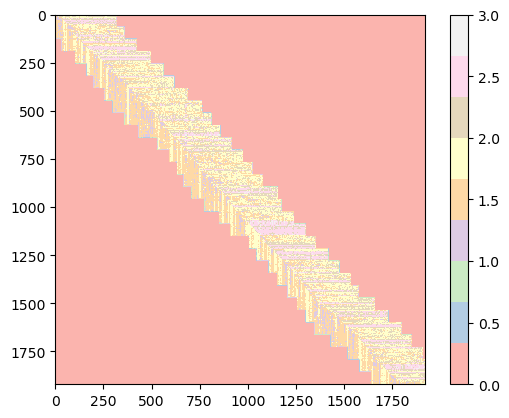

In [21]:
plt.imshow(Trace[:, :], cmap='Pastel1')
plt.colorbar()
plt.show()

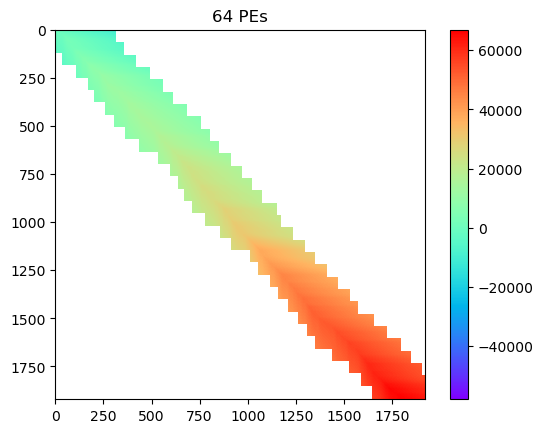

Score: 66965.0 Position: (1911, 1793)
Local Max: 66965.0 Position: (1911, 1793)


In [22]:
plt.imshow(V[:, :], cmap='rainbow')
plt.colorbar()
plt.title(f'{num_PE} PEs')
plt.show()
print('Score:', V_max, f'Position: {x_max, y_max}')
print('Local Max:', V_max_local, f'Position: {x_max_local, y_max_local}')

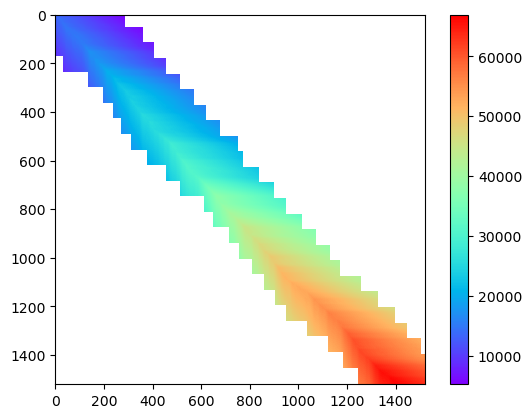

Score: 66965.0 Position: (1911, 1793)
Local Max: 66965.0 Position: (1911, 1793)


In [23]:
plt.imshow(V[400:, 400:], cmap='rainbow')
plt.colorbar()
plt.show()
print('Score:', V_max, f'Position: {x_max, y_max}')
print('Local Max:', V_max_local, f'Position: {x_max_local, y_max_local}')

In [24]:
seq_1 = ''
seq_2 = ''
result = ''
# which matirx are we tracking now
target_matrix = 'T'

x, y = x_max, y_max
while(x != 0) and (y != 0):
    if target_matrix == 'T':
        # print('T', Trace[x][y], x, y)
        if Trace[x][y] == 1:
            seq_1 = gene_1[x-1] + seq_1
            seq_2 = gene_2[y-1] + seq_2
            if gene_1[x-1] == gene_2[y-1]:
                result = '|' + result
            else:
                result = ' ' + result
            x, y = x-1, y-1
        # if direction = top, move to Trace_D
        elif Trace[x][y] == 2:
            if Trace_D[x][y] == 0:
                target_matrix = 'D'
            seq_1 = gene_1[x-1] + seq_1
            seq_2 = '-' + seq_2
            result = ' ' + result
            x, y = x-1, y
        # if direction = left, move to Trace_I
        elif Trace[x][y] == 3:
            if Trace_I[x][y] == 0:
                target_matrix = 'I'
            seq_1 = '-' + seq_1
            seq_2 = gene_2[y-1] + seq_2
            result = ' ' + result
            x, y = x, y-1
    elif target_matrix == 'D':
        # print('D', Trace_D[x][y], x, y)
        # move to Trace if reach gap origin
        if Trace_D[x][y] == 1:
            target_matrix = 'T'
        seq_1 = gene_1[x-1] + seq_1
        seq_2 = '-' + seq_2
        result = ' ' + result
        x, y = x-1, y
    elif target_matrix == 'I':
        # print('I', Trace_I[x][y], x, y)
        # move to Trace if reach gap origin
        if Trace_I[x][y] == 1:
            target_matrix = 'T'
        seq_1 = '-' + seq_1
        seq_2 = gene_2[y-1] + seq_2
        result = ' ' + result
        x, y = x, y-1

parts = len(seq_1)//width + 1
for i in range(parts):
    print(seq_1[i*width:min(i*width+width, len(seq_1))])
    print(result[i*width:min(i*width+width, len(result))])
    print(seq_2[i*width:min(i*width+width, len(seq_2))])
    print('')

print(seq_1 == seq_1_ans)
print(seq_2 == seq_2_ans)

ATTACTTG-------CATGACGAT-----CGTTGGTCGGCTCTTAACCCGGCGTTTAGCC
||| | ||       |||||| ||     ||||||||| ||||||||||||| |||||||
ATTGCGTGGGCATTTCATGACCATGTTTCCGTTGGTCGCCTCTTAACCCGGCTTTTAGCC

TCA--ATGAACTGCAATCCGTTTCGCCAGTGCCCTGGTCAAGGCAGTTCTTCGTTACTTT
||   ||||        ||||       ||||||| |||    ||  |||||||||||||
TCGCCATGA--------CCGT-------GTGCCCTCGTC----CAACTCTTCGTTACTTT

CTGTTCTATAA--TAAGACATTCTTTGGTTGCCGACTAAGTCGAAAGCTCGTCGCACTCA
|||||||||||  | || ||||||||||  |||||||||||||||| | |  || |  ||
CTGTTCTATAATCTGAGCCATTCTTTGG--GCCGACTAAGTCGAAA-CGCCACGTAGCCA

GTTTCGGAACTTTCATAAGGGTTCGTGTG-TTGGGTTTTAG---TCTAGAG-------GA
|||||||||||||||||||||| || |   ||||||||||    |||||||       ||
GTTTCGGAACTTTCATAAGGGTGCGGGCACTTGGGTTTTAACATTCTAGAGGAACTACGA

TGGCCCGAACATCTATCGCGAAAGTGCCAGCAGATTGACTTTTCGTGTTCATCACCTGTA
|||||||||||| |||||||||||||||       |||||||||        ||||   |
TGGCCCGAACATATATCGCGAAAGTGCC-------TGACTTTTC--------CACC---A

ACGCACAGCGATTAG-------CTCCTTGACCT--CTATA----------CATGGAGTCG
||||||||||||| |    